# XGBoost

## Load data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from collections import defaultdict
import datetime
import pickle
import math
import os
from xgboost import plot_importance
from scipy.stats import skew, norm
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None) # no truncate columns

In [2]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "preprocessing"
with open(data_path_out + 'train_pp.obj', 'rb') as file:
    train = pickle.load(file)
with open(data_path_out + 'test_pp.obj', 'rb') as file:
    test = pickle.load(file)

## Utilities

In [3]:
filter_startswith = lambda l,s: [x for x in l if x.startswith(s)]

# regional features
r_regions = ['Region_'+str(i) for i in range(11)]
r_assortments = filter_startswith(train.columns, 'AssortmentType_')
r_storetype = filter_startswith(train.columns, 'StoreType_')
r_general = ['NearestCompetitor', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'Region_PD']
regional_features =  r_regions + r_assortments + r_storetype + r_general

# meteo features
m_events = filter_startswith(train.columns, 'Events_')
m_general = ['CloudCover', 'Max_Dew_PointC', 'Max_Humidity', 'Max_Sea_Level_PressurehPa',
             'Max_TemperatureC', 'Max_VisibilityKm', 'Max_Wind_SpeedKm_h',
             'Mean_Dew_PointC', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa',
             'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h',
             'Min_Dew_PointC', 'Min_Humidity', 'Min_Sea_Level_PressurehPa',
             'Min_TemperatureC', 'Min_VisibilitykM', 'Precipitationmm',
             'WindDirDegrees']
meteo_features =  m_events + m_general

# store features
store_features = ['IsHoliday', 'IsOpen', 'HasPromotions', 'Hol_and_open']

# seasonal features
seasonal_features = ['week_of_month', 'year', 'quarter', 'month', 'day_of_month',
                     'day_of_week', 'day_of_year', 'WeekOfYear', 'days_in_month',
                     'HolidaysWeekBefore', 'HolidaysWeekCurrent', 'HolidaysWeekAfter',
                     'PromoWeekBefore', 'PromoWeekCurrent', 'PromoWeekAfter']

# x and y specific
x_features = ['StoreID']
y_features = ['NumberOfSales']

In [4]:
# split train set in x and y
def split_dataset(dataset):
    x = dataset.drop('NumberOfSales', axis=1)
    y = dataset.NumberOfSales
    
    return (x, y)

# split train set by months
def split_dataset_bymonth(test_year, test_months, train_set):
    test_mask = (train_set.year == test_year) & train_set.month.isin(test_months)

    # define the train set
    train_dataset = train_set[~test_mask]
    x_train, y_train = split_dataset(train_dataset)
    
    # define the test set
    test_dataset = train_set[test_mask]
    x_test, y_test = split_dataset(test_dataset)
    
    return (x_train, y_train, x_test, y_test)

In [5]:
# reorder results monthly wrt regions, stores pairing predictions with actual values
def get_regional_results(x, y, results):
    # create the dataframe
    df_results = x[['StoreID', 'month'] + r_regions].copy()
    df_results['predicted'] = results
    df_results['actual'] = y
    
    # aggregate prediction monthly
    df_results = df_results.groupby(['StoreID', 'month']+r_regions)\
    .agg({'predicted': 'sum', 'actual': 'sum'}).reset_index()
    
    # create dictionary results
    region_results = {}
    for regionID in range(0,11):
        df_region = df_results[df_results['Region_' + str(regionID)] == 1]\
        .drop(r_regions, axis=1)

        store_results = {}
        for storeID, store in df_region.groupby('StoreID'):
            store_results[storeID] = store.drop('StoreID', axis=1)\
            .set_index('month').T.to_dict()

        region_results[regionID] = store_results
        
    return region_results

In [6]:
# Lanzi error

# region_error inputs:
#
# dict predictions = {
#     int storeID: {
#         int month: { str 'predicted': float, str 'actual': float }
#         ...
#     }
#     ...
# }
def region_error(predictions):
    num = 0
    den = 0
    for months in predictions.values():
        for values in months.values():
            num += abs(values['actual'] - values['predicted'])
            den += values['actual']
    
    return num/den
    
# total_error input:
#
# region_errors = [0.3, 0.5, ... ]
def total_error(region_errors):
    return sum(region_errors)/len(region_errors)

def lanzi_error(regional_results):
    region_errors = []
    for region in regional_results.values():
        region_errors.append(region_error(region))
    
    return total_error(region_errors)

## Preprocessing

In [7]:
# Robust Scaler
rs = RobustScaler()

features_to_scale = r_general + m_general

train[features_to_scale] = rs.fit_transform(train[features_to_scale])
test[features_to_scale] = rs.fit_transform(test[features_to_scale])

In [8]:
# drop useless features
features_to_drop = m_general + ['Region', 'Date']

train = train.drop(labels=features_to_drop, axis=1)
test = test.drop(labels=features_to_drop, axis=1)

## Train and predict

### Model

In [9]:
# settings
xgboost_params = {    
    'max_depth': 9,
    'learning_rate': 0.2,
    'n_jobs': 4,
    'silent': False
}

kfold_params = {
    'n_splits': 5,
    'shuffle': True,
    'random_state': 7
}

In [10]:
# Cross validation score
x_train, y_train = split_dataset(train)

model = XGBRegressor(**xgboost_params)
kfold = KFold(**kfold_params)
results = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold, verbose=2)

print('Cross-validation score: {:.4f} with +/- {:.4f}'\
      .format(results.mean(),results.std()))

[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ................................................. , total= 1.4min
[CV]  ................................................................
[CV] ................................................. , total= 1.5min
[CV]  ................................................................
[CV] ................................................. , total= 1.3min
[CV]  ................................................................
[CV] ................................................. , total= 1.3min
Cross-validation score: 0.9569 with +/- 0.0008


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min finished


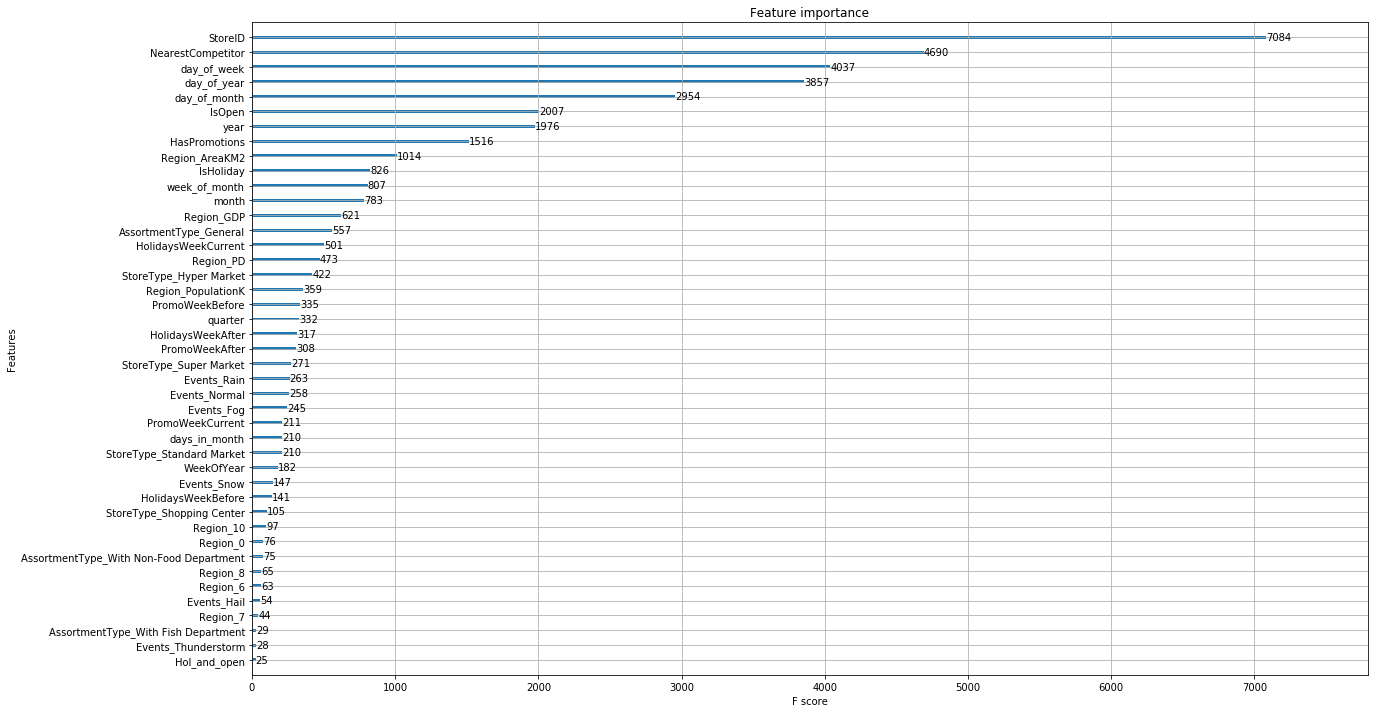

In [11]:
# Feature importance plot
model.fit(x_train, y_train)
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plot_importance(model, ax=ax)
plt.show()

In [12]:
# results = {}
# for storeid in all_train.StoreID.unique():
#     train = all_train[all_train.StoreID == storeid]
#     y_train = train.NumberOfSales
#     x_train = train.drop('NumberOfSales',axis = 1)
    
#     model = XGBRegressor(silent=False)
#     kfold = KFold(n_splits=10, shuffle = True, random_state=7)
#     results[storeid] = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold)
#     print('Cross-validation for {} -> score: {:.4f} with +/- {:.4f}'\
#           .format(storeid,results[storeid].mean(),results[storeid].std()))

In [13]:
# df_results = pd.DataFrame.from_dict(results).T
# df_results_mean = df_results.mean(axis=1)
# df_results_mean[df_results_mean < 0.8]

## Lanzi Error

In [14]:
# Split train set and predict the test set
x_train, y_train, x_test, y_test =\
    split_dataset_bymonth(2017, [3, 4], train)

model = XGBRegressor(**xgboost_params)
model.fit(x_train, y_train)

results = model.predict(x_test)

In [15]:
regional_results = get_regional_results(x_test, y_test, results)
print('Lanzi error: {}'.format(lanzi_error(regional_results)))

Lanzi error: 0.0431061765573909


## Score submit [TODO]

In [11]:
# Load test set to predict
with open(data_path_out + 'test_pp.obj', 'rb') as file:
    all_test = pickle.load(file)
    
all_test = all_test.drop(labels=['Region', 'Date'], axis=1)

# HACK: remove differential
all_train = all_train.drop(labels=['Differential'], axis=1)

print(all_test.shape)
all_train.head()

(45689, 85)


,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,Hol_and_open,Region_PD,week_of_month,year,quarter,month,day_of_month,day_of_week,day_of_year,WeekOfYear,days_in_month,Region_0,Region_1,Region_10,Region_2,Region_3,Region_4,Region_5,Region_7,Region_9,Region_6,Region_8,AssortmentType_General,AssortmentType_With Non-Food Department,AssortmentType_With Fish Department,StoreType_Hyper Market,StoreType_Standard Market,StoreType_Super Market,StoreType_Shopping Center,Events_Fog,Events_Fog-Rain,Events_Fog-Rain-Hail,Events_Fog-Rain-Hail-Thunderstorm,Events_Fog-Rain-Snow,Events_Fog-Rain-Snow-Hail,Events_Fog-Rain-Thunderstorm,Events_Fog-Snow,Events_Fog-Snow-Hail,Events_Fog-Thunderstorm,Events_Normal,Events_Rain,Events_Rain-Hail,Events_Rain-Hail-Thunderstorm,Events_Rain-Snow,Events_Rain-Snow-Hail,Events_Rain-Snow-Hail-Thunderstorm,Events_Rain-Snow-Thunderstorm,Events_Rain-Thunderstorm,Events_Snow,Events_Snow-Hail,Events_Thunderstorm,HolidaysWeekBefore,HolidaysWeekCurrent,HolidaysWeekAfter,PromoWeekBefore,PromoWeekCurrent,PromoWeekAfter,NumberOfSales
0,1000,False,True,False,326,9643,17130,2770,8.0,1,100,1032,2,19.0,21,-1,82,1030,1,11.0,16,-2,70,1029,1,6.0,0.0,23,False,0.287255,0,2016,1,3,1,1,61,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,5676
1,1000,False,True,False,326,9643,17130,2770,8.0,0,87,1030,5,23.0,16,-1,73,1027,3,13.0,10,-2,58,1025,1,10.0,0.0,56,False,0.287255,0,2016,1,3,2,2,62,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,8111
2,1000,False,True,False,326,9643,17130,2770,8.0,0,81,1026,4,31.0,23,-1,71,1024,3,11.0,10,-3,55,1023,2,8.0,0.0,22,False,0.287255,0,2016,1,3,4,4,64,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,8300
3,1000,False,True,False,326,9643,17130,2770,6.0,-3,80,1027,8,31.0,19,-4,56,1024,3,15.0,10,-6,25,1022,-1,10.0,0.0,108,False,0.287255,0,2016,1,3,5,5,65,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7154
4,1000,False,False,False,326,9643,17130,2770,6.0,0,93,1025,7,31.0,16,-3,75,1023,1,12.0,5,-6,48,1022,-5,5.0,0.0,46,False,0.287255,0,2016,1,3,6,6,66,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0


In [12]:
# Create submit dataframe
data_path_in = 'Data/input/'
data_type = {
    'StoreID': 'uint16',
    'Month': 'uint8',
    'NumberOfSales': 'uint32'
}

df_submission = pd.read_csv(data_path_in+'sample_submission.csv', dtype=data_type)
df_submission.head()

,StoreID,Month,NumberOfSales
0,1000,3,0
1,1000,4,0
2,1001,3,0
3,1001,4,0
4,1002,3,0


In [23]:
# train and test set prediction
print_score = False
month_list = df_submission.Month.unique()

for storeid in all_test.StoreID.unique():
    # split dataset
    train_current_store = all_train[all_train.StoreID == storeid]
    test_current_store = all_test[all_test.StoreID == storeid]
    
    x_train = train_current_store.drop('NumberOfSales', axis=1)
    y_train = train_current_store.NumberOfSales
    x_test = all_test
    
    # train the model with the training set
    model = XGBRegressor(silent=False)
    model.fit(x_train, y_train)
    print(storeid)
    # Score
    if print_score:
        kfold = KFold(n_splits=5, shuffle=True, random_state=7)
        cv_score = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold)
        print('Cross-validation for {} -> score: {:.4f} with +/- {:.4f}'\
              .format(storeid, cv_score.mean(), cv_score.std()))
    
    # predict the test set with the trained model
    for month in month_list:
        mask = (df_submission.StoreID == storeid) & (df_submission.Month == month)
        month_prediction = model.predict(x_test[x_test.month == month])
        df_submission.at[mask, 'NumberOfSales'] = np.sum(month_prediction)

1000
1001


In [24]:
# write submission csv
df_submission.to_csv(data_path_out+'submission.csv', index=False)